# Prospecção de Dados (Data Mining) DI/FCUL - HA3

## Third Home Assignement (MC/DI/FCUL - 2024)

### Fill in the section below

### GROUP: `02`

* João Martins, 62532 - Hours worked on the project: 8
* Rúben Torres, 62531 - Hours worked on the project: 8
* Nuno Pereira, 56933 - Hours worked on the project: 8




The purpose of this Home Assignment is
* Find similar items with Local Sensitivity Hashing
* Do Dimensionality Reduction

**NOTE 1: Students are not allowed to add more cells to the notebook**

**NOTE 2: The notebook must be submited fully executed**

**NOTE 3: Name of notebook should be: HA3_GROUP-XX.ipynb (where XX is the group number)**



## 1. Read the Dataset

The dataset correspond to about 99% of the Human Proteome (set of known Human Proteins - about 19,500), coded with specific structural elements. They are presented in a dictionary where the key is the [UniprotID](https://www.uniprot.org/) of the protein and the value is a set of indices of a specific structural characteristic

Students can use one of two datasets, that are **not** subsets of each other: 
* `data_d3.pickle` - smaller set of structural features (2048)
* `data_d4.pickle` - much larger set of structural features (20736) **Note:** This dataset has been Zipped to fit into moodle. Students should unzip it before usage 

Select **one** of the datasets and perform all analyses with it. 

It may be adviseable the usage of sparse matrices, especially for the `d4` dataset



In [1]:
from itertools import combinations

import matplotlib.pyplot as plt
import numpy as np
import pickle

human_proteins_dataset = pickle.load(open("data_d3.pickle", "rb"))

proteomes = [proteome for proteome in human_proteins_dataset.keys()]

group_protein_sets = [
    set(human_proteins_dataset[protein]) for protein in human_proteins_dataset
]

unique_proteins = sorted(
    set(protein for proteins in group_protein_sets for protein in proteins)
)

protein_to_index = {protein: index for index, protein in enumerate(unique_proteins)}

result_array = np.zeros((len(group_protein_sets), len(unique_proteins)), dtype=int)
for row_index, proteins in enumerate(group_protein_sets):
    for protein in proteins:
        col_index = protein_to_index[protein]
        result_array[row_index, col_index] = 1

## 2. Perform Local Sensitivity Hashing (LSH)

* examine the selected dataset in terms of similarities and select a set of LSH parameters able to capture the most similar proteins
* Comment your results

**BONUS POINTS:** It might be interesting to identify **some** of the candidate pairs in Uniprot, to check if they share some of the same properties (e.g. for [protein P28223](https://www.uniprot.org/uniprotkb/P28223/entry))


In [2]:
def MakeBucketsTs(TDocs, perms, N, B, R, M, NB):
    Buckets = {}
    all_docs = set(range(N))
    for b in range(B):
        SIGS = np.zeros((N, R), dtype="int32")
        for r in range(R):
            perm = perms[b * R + r]
            L = all_docs.copy()
            i = 0
            while len(L) > 0:
                elem = perm[i]
                docs_found = TDocs[elem] & L
                if len(docs_found) > 0:
                    SIGS[list(docs_found), r] = i
                    L = L - docs_found
                i += 1
                if i == M:
                    SIGS[list(L), r] = i
                    L = {}

        for d in range(N):
            bucket = hash(tuple(SIGS[d])) % NB
            Buckets.setdefault((b, bucket), set()).add(d)
    return Buckets


def LSHT(Data, B, R, NB=28934501, verbose=True):
    N, M = Data.shape
    if verbose:
        print("transpose the data set")
    DT = Data.T
    DataT = [set(np.where(DT[i] == 1)[0]) for i in range(M)]
    P = B * R
    np.random.seed(3)
    if verbose:
        print(
            "Generating %d permutations for %6.3f similarity" % (P, (1 / B) ** (1 / R))
        )
    perms = [np.random.permutation(M) for i in range(P)]
    if verbose:
        print("Computing buckets...")
    buckets = MakeBucketsTs(DataT, perms, N, B, R, M, NB)
    return buckets


def JaccardSim(d1, d2):
    a = np.inner(d1, d2)
    bc = np.sum(d1 + d2) - a
    return a / bc


def get_all_similar_docs(buckets):
    sim_docs = []
    for b, buck in buckets:
        if len(buckets[(b, buck)]) > 1:
            sim_docs += combinations(buckets[(b, buck)], 2)
    sim_docs = set(sim_docs)
    D = {}
    for i, j in sim_docs:
        D.setdefault(i, set()).add(j)
        D.setdefault(j, set()).add(i)
    return D

In [3]:
BANDS = 200
ROWS = 10

similar = 0.6
P = 1 - (1 - similar**ROWS) ** BANDS
print(
    "The probability that documents share at least one band signature if they are %4.2f similar is: %7.4f\n"
    % (similar, P)
)

similar = 0.70
P = 1 - (1 - similar**ROWS) ** BANDS
print(
    "The probability that documents share at least one band signature if they are %4.2f similar is: %7.4f\n"
    % (similar, P)
)

l = []
bucks = LSHT(result_array, BANDS, ROWS)
for b, buck in bucks:
    if len(bucks[(b, buck)]) > 1:
        # print("Band", b, "suggests these similar docs:", bucks[(b, buck)])
        combs = combinations(bucks[(b, buck)], 2)
        for i, j in combs:
            jac = JaccardSim(result_array[i], result_array[j])
            if jac >= 0.8:
                l.append((i, j, jac))
                # print("Documents %6d and %6d are in truth %7.4f similar" % (i, j, jac))

s = set(l)
top = sorted(s, key=lambda tuple: tuple[2], reverse=True)[:20]
for i, j, jac in top:
    print(
        "Proteins %s and %s are in truth %7.4f similar"
        % (proteomes[i], proteomes[j], jac)
    )

The probability that documents share at least one band signature if they are 0.60 similar is:  0.7027

The probability that documents share at least one band signature if they are 0.70 similar is:  0.9968

transpose the data set
Generating 2000 permutations for  0.589 similarity
Computing buckets...
Proteins A0A0B4J2D9 and P0DP09 are in truth  1.0000 similar
Proteins P0DTE7 and P0DTE8 are in truth  0.9926 similar
Proteins A0A087WW87 and P01614 are in truth  0.9922 similar
Proteins P01614 and A0A087WW87 are in truth  0.9922 similar
Proteins B3EWG6 and B3EWG3 are in truth  0.9907 similar
Proteins B3EWG6 and B3EWG5 are in truth  0.9907 similar
Proteins P0C7P1 and P0DJD4 are in truth  0.9870 similar
Proteins P0DPF7 and A0A0J9YXY3 are in truth  0.9858 similar
Proteins A0A0J9YXY3 and P0DPF7 are in truth  0.9858 similar
Proteins P0DP03 and P01768 are in truth  0.9845 similar
Proteins A0A075B6P5 and P01615 are in truth  0.9840 similar
Proteins P01615 and A0A075B6P5 are in truth  0.9840 similar

### Your short analysis here

Above we can observe a list of the top 20 most similar proteins, we made a matrix composed by bit values which represents each proteom of the protein and for that we used 200 bands and 10 rows, the first two proteins have, indeed, the structure of proteoms based on HLA Ligand Atlas.


## 3. Do dimensionality reduction 

Use the techniques discussued in class to make an appropriate dimensional reduction of the selected dataset. It is not necesary to be extensive, **it is better to select one approach and do it well than try a lot of techniques with poor insights and analysis**

It is important to do some sensitivity analysis, relating the dataset size reduction to the loss of information



In [4]:
def plot_component_representation(X, Y, xlabel, ylabel) -> None:
    plt.plot(X, Y, label="SVD")
    plt.legend()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid()
    plt.show()


def scatter_plot(concept_matrix, identifier, verbose=False) -> None:
    plt.scatter(concept_matrix[:, 0], concept_matrix[:, 1], marker="o")
    if verbose:
        for i, txt in enumerate(identifier):
            plt.annotate(txt, (concept_matrix[i, 0], concept_matrix[i, 1]))
    plt.grid()
    plt.show()

U shape:  (19258, 19258)
S shape:  (2048,)
V shape:  (2048, 2048)
first 1318 components have a combined importance of  0.8996
first 1319 components have a combined importance of  0.8999
first 1320 components have a combined importance of  0.9001
first 1321 components have a combined importance of  0.9004


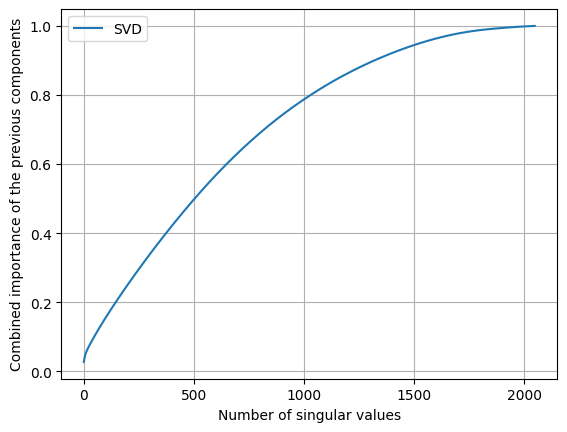

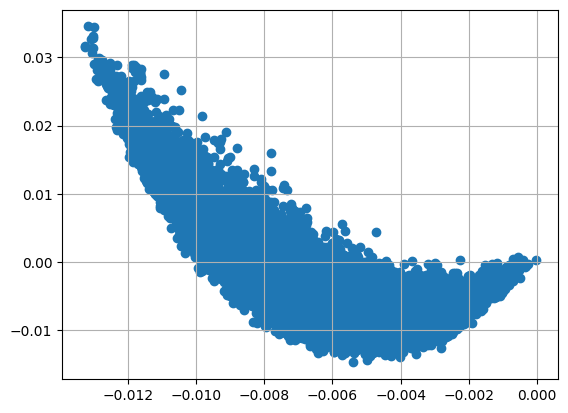

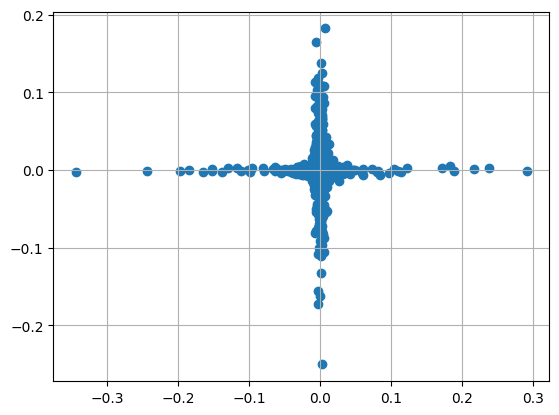

The MSE with 1320 components is:  0.0019


In [5]:
u, s, v = np.linalg.svd(result_array)

np.set_printoptions(precision=4, suppress=True)
print("U shape: ", u.shape)
print("S shape: ", s.shape)
print("V shape: ", v.shape)

components_number = []
consept_representation = []
for i in range(len(s)):
    if round((s[: i + 1].sum() / s.sum()) * 1000) / 1000 == 0.9:
        print(
            "first %d components have a combined importance of %7.4f"
            % (i + 1, s[: i + 1].sum() / s.sum())
        )
    components_number.append(i)
    consept_representation.append(s[: i + 1].sum() / s.sum())

plot_component_representation(
    components_number,
    consept_representation,
    "Number of singular values",
    "Combined importance of the previous components",
)

scatter_plot(u, proteomes)
scatter_plot(v, proteins)

r=1320
U = u[:,:r]
S = np.diag(s[:r])
V = v[:r, :]
MSE=((result_array - U @ S @ V)**2).mean()
print("The MSE with %d components is: %7.4f" % (r, MSE))

## 4. Discuss your findings [to fill on your own]

* Comment your results above
* Discuss how could they be used for the full Uniprot that currently has about [248 Million proteins](https://www.uniprot.org/uniprotkb/statistics)


In this topic we used the SVD because of it's abilities to cope with huge matrices, for the component decomposition, with SVD we could identify that combining only the first 1320 components out of 2048, we were capable of representing 90% of the concept space with an MSE of only 0.0019. On the first graph we can see the combined importance of components, it shows that it is not needed to use all proteoms to keep the combined information.
On the second graph we can observe the distribution of proteoms after applying the u matrix extraction, and the third graph we can see the destribution of proteins after v matrix extraction from SVD.
